<a href="https://colab.research.google.com/github/ajain625/ML_experiements/blob/main/COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my attempt at building an object detector using a small sample of the COCO database. I have largely used FastAI (a library built on top of PyTorch) to achieve this. The small sample I have considered has about 22,000 images containing one or more of the following objects: book, chair, couch, remote, tv, vase. 

I have been able to achieve 84% accuracy using resnet50 as my model and Leslie Smith's Super Convergence technique.

The notebook is ready to run. You may also choose to upload any image you want and test out what the model predicts. Currently the model is equipped to handle 128x128 RGB images. If you upload an image of a different size, the model will randomly crop out a section of the aforementioned dimension. For best results, please upload images of size 128*128.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 720 kB 23.7 MB/s 
     |████████████████████████████████| 48 kB 7.0 MB/s 
     |████████████████████████████████| 189 kB 71.3 MB/s 
     |████████████████████████████████| 1.2 MB 58.4 MB/s 
     |████████████████████████████████| 55 kB 5.0 MB/s 
     |████████████████████████████████| 558 kB 74.6 MB/s 
     |████████████████████████████████| 51 kB 400 kB/s 
     |████████████████████████████████| 130 kB 62.9 MB/s 
Mounted at /content/gdrive


In [60]:
from fastai.vision.all import *
path = untar_data(URLs.COCO_SAMPLE)

In [3]:
import json

with open(path/'annotations'/'train_sample.json') as f:
  data = json.load(f)
data.keys()

dict_keys(['categories', 'annotations', 'images'])

In [4]:
category_list = data['categories']
image_list = data['images']
annotations_list = data['annotations']

image_dic = {}
for i in image_list:
  image_dic[i['id']] = i['file_name']

annotations_dic = {}
for i in annotations_list:
  if i['image_id'] in annotations_dic:
    annotations_dic[i['image_id']].append(i['category_id'])
  else:
    annotations_dic[i['image_id']] = [i['category_id']]

category_dic = {}
for i in category_list:
  category_dic[i['id']] = i['name']

In [6]:
def get_image(df): return path/'train_sample'/df['fname']
def get_labels(df): return df['labels']

In [7]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_image, get_y = get_labels, splitter = RandomSplitter(valid_pct=0.2, seed=42), item_tfms = RandomResizedCrop(128, min_scale=0.5))
dsets = dblock.datasets(df)
dsets.valid

(#4367) [(PILImage mode=RGB size=640x640, TensorMultiCategory([0., 0., 0., 0., 1., 0.])),(PILImage mode=RGB size=640x480, TensorMultiCategory([0., 1., 0., 1., 0., 0.])),(PILImage mode=RGB size=640x480, TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=640x428, TensorMultiCategory([1., 0., 0., 0., 0., 0.])),(PILImage mode=RGB size=640x429, TensorMultiCategory([0., 1., 0., 0., 0., 0.])),(PILImage mode=RGB size=480x640, TensorMultiCategory([0., 0., 0., 1., 1., 0.])),(PILImage mode=RGB size=640x428, TensorMultiCategory([1., 0., 1., 1., 0., 1.])),(PILImage mode=RGB size=640x480, TensorMultiCategory([1., 1., 1., 1., 0., 0.])),(PILImage mode=RGB size=640x427, TensorMultiCategory([0., 1., 0., 0., 0., 0.])),(PILImage mode=RGB size=480x640, TensorMultiCategory([1., 0., 0., 0., 0., 0.]))...]

In [61]:
dls = dblock.dataloaders(df)

In [9]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [45]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.55))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [46]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.543665,0.414800,0.821579,03:05
1,0.408925,0.363762,0.839707,02:56
2,0.372602,0.355813,0.843066,02:55


Upload your image and provide its path below.
The cells below will display your image, display the possible predictions in order and finally the confidence percentages for each category (default threshold for successful prediction is set to 0.55)

In [59]:
test_path = "/content/booktv.jpg"

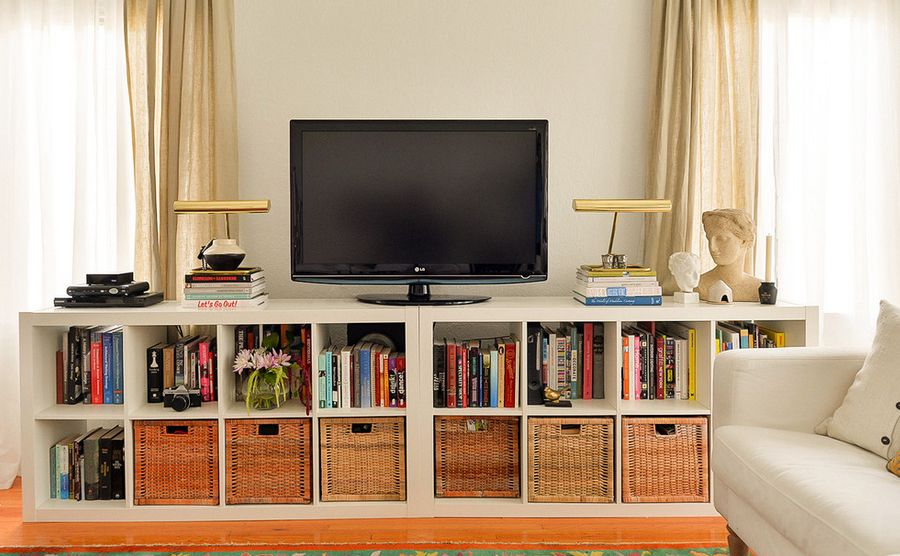

In [54]:
from IPython import display
display.Image(test_path)

In [76]:
dsets.train.vocab

['book', 'chair', 'couch', 'remote', 'tv', 'vase']

In [78]:
learn.predict(test_path)

((#1) ['tv'],
 TensorBase([False, False, False, False,  True, False]),
 TensorBase([0.4524, 0.2871, 0.1808, 0.0701, 0.8645, 0.2480]))